<a href="https://colab.research.google.com/github/hasitanalluri/mlgroupproject/blob/main/ML_Final_Project_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Overall Question: What data can government agencies such as the CDC collect to effectively predict hospital strain?

Specific Questions:
1.   Can we predict whether a state will experience significant staff shortages (hospital strain) using collectible data?
2.   If so, which features in our dataset are most important for predicting hospital strain (drive hospital strain)?




In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# We downloaded our dataset from https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh/about_data
df = pd.read_csv('/content/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries__RAW__20250227.csv')
#print(df.head())

In [120]:
# Create new variable, proportion of hospitals experiencing critical staffing shortages
df['critical_staffing_shortage_today_prop'] = df['critical_staffing_shortage_today_yes'] / (df['critical_staffing_shortage_today_yes'] + df['critical_staffing_shortage_today_no'])
print("Original df size:", df.shape)
print(df[['critical_staffing_shortage_today_prop']].isnull().any(axis=1).sum())
df = df.dropna(subset=['critical_staffing_shortage_today_prop']) # Remove missing values
print("New df size:", df.shape)

Original df size: (81713, 136)
10880
New df size: (70833, 136)


In [121]:
# Clean data for the number of inpatient beds utilized (inpatient_beds_utilization)
print("Original df size:", df.shape)
print(df[['inpatient_beds_utilization']].isnull().any(axis=1).sum())
df = df.dropna(subset=['inpatient_beds_utilization']) # Remove missing values
print("New df size:", df.shape)

Original df size: (70833, 136)
0
New df size: (70833, 136)


In [122]:
columns_with_missing = df.columns[df.isnull().any()]
#print(columns_with_missing)
print(df.shape)
# Drop all columns with missing values
df = df.dropna(axis=1)
print(df.shape)

(70833, 136)
(70833, 66)


In [123]:
# Normalize all numerical variables
from sklearn.preprocessing import MinMaxScaler

# Create a scaler
scaler = MinMaxScaler()

# Select only numerical columns
num_cols = df.select_dtypes(include=['number']).columns

# Fit and transform the numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])

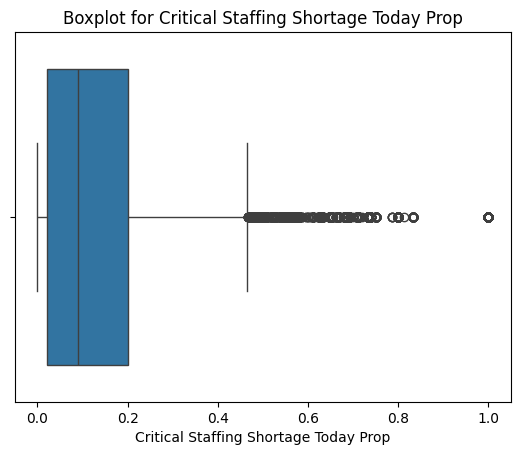

count    70833.000000
mean         0.149883
std          0.193110
min          0.000000
25%          0.021978
50%          0.090000
75%          0.200000
max          1.000000
Name: critical_staffing_shortage_today_prop, dtype: float64


In [124]:
# Logistic regression to predict hospital strain
# Determine criteria for high and low strain

# Boxplot
sns.boxplot(x=df['critical_staffing_shortage_today_prop'])
plt.title('Boxplot for Critical Staffing Shortage Today Prop')
plt.xlabel('Critical Staffing Shortage Today Prop')
plt.show()

# Five-number summary
five_num_summary = df['critical_staffing_shortage_today_prop'].describe()
print(five_num_summary)

The 75th percentile % is 0.2, meaning that 75% of all hospitals in a state that day are experiencing a critical staff shortage of 20% or less. We will define 'high strain' as when a state is in the upper quartile for critical_staffing_shortage_today_prop, meaning more than 20% of hospitals in that state on that day are experiencing a critical staffing shortage.

In [125]:
# Create variable, strain
df['strain'] = (df['critical_staffing_shortage_today_prop'] > 0.2).astype(int)

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df.select_dtypes(include=['number'])
X = X.drop(['critical_staffing_shortage_today_prop',
             'critical_staffing_shortage_today_yes',
             'critical_staffing_shortage_today_no', 'strain'], axis=1)

# Include state as variable in log model
df_dummies = pd.get_dummies(df['state'],dtype='int')
df = df.dropna(subset=['state'])
X = pd.concat([X, df_dummies], axis=1)

y = df['strain'] # Target variable

# Split the sample:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LogisticRegression(penalty=None,
                         fit_intercept=True,
                         solver='newton-cholesky',
                         max_iter=1000).fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_glm/_newton_solver.py:576: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=7.14603e-17): result may not be accurate.
  warnings.warn(


Accuracy on training data:  0.8923163801927082
Accuracy on test data:  0.8887555586927366


In [134]:
print('Accuracy on training data: ', reg.score(X_train, y_train))
print('Accuracy on test data: ', reg.score(X_test, y_test))

y_pred = reg.predict(X_test)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print("\n", confusion_matrix)

Accuracy on training data:  0.8923163801927082
Accuracy on test data:  0.8887555586927366

 Predicted      0     1    All
Actual                       
0          10150   541  10691
1           1035  2441   3476
All        11185  2982  14167


Based on the accuracy values of 89.2% on the training data and 88.9% on the testing data, the logistic regression model performed very well to predict hospital strain. The similarity in accuracy rates between accuracy rates on training and test data indicates that overfitting did not occur, which is a good sign. Thus, we have sufficient reason to believe that **we can indeed predict whether a state will experience significant staff shortages using collectible data.**

In [136]:
# Extract counts from confusion matrix
tn = confusion_matrix.loc[0, 0]
fp = confusion_matrix.loc[0, 1]
fn = confusion_matrix.loc[1, 0]
tp = confusion_matrix.loc[1, 1]

# Total actual positives and negatives
actual_positives = tp + fn
actual_negatives = tn + fp
total = tp + tn + fp + fn

# Compute rates
tpr = tp / actual_positives  # True Positive Rate
tnr = tn / actual_negatives  # True Negative Rate
fpr = fp / actual_negatives  # False Positive Rate
fnr = fn / actual_positives  # False Negative Rate
accuracy = (tp + tn) / total

# Display
print(f"\nTrue Positive Rate: {tpr:.2f}")
print(f"True Negative Rate: {tnr:.2f}")
print(f"False Positive Rate: {fpr:.2f}")
print(f"False Negative Rate: {fnr:.2f}")
print(f"Overall Accuracy: {accuracy:.2f}")


True Positive Rate: 0.70
True Negative Rate: 0.95
False Positive Rate: 0.05
False Negative Rate: 0.30
Overall Accuracy: 0.89


The model has a very low false positive rate and a high true negative rate, which is beneficial because it rarely triggers false alarms when predicting hospital strain. This suggests that if the model's predictions were used to guide resource allocation, it would minimize the risk of unnecessarily directing resources to states that don’t need them.

However, the model misses about 30% of actual hospital strain cases, as indicated by its false negative rate. While the model is reasonably effective at identifying strain overall, this gap means a reasonable portion of strained hospitals may go unrecognized — potentially leading to under-allocation of support in those areas. In a real-world setting, this could translate to delayed or insufficient intervention where it's most needed.

One reason for the gap in our model's predictions could be the skewed distribution of our data, where 75% of the observations represent "low strain" situations. This imbalance may cause the model to favor predicting the majority class (low strain), leading to a higher false negative rate for the minority class (high strain).

In [139]:
# Use random forests to determine what features are driving strain
from sklearn.ensemble import RandomForestRegressor

# Fit model:
model = RandomForestRegressor(max_depth=10) # Build a random forest model
rf = model.fit(X_train,y_train) # Fit the rf model

# Make predictions:
y_hat_rf = rf.predict(X_test) # Model predictions

In [63]:
print( 'Rsq: ', rf.score(X_test,y_test) ) # Rsq measure

Rsq:  0.8175493411659145


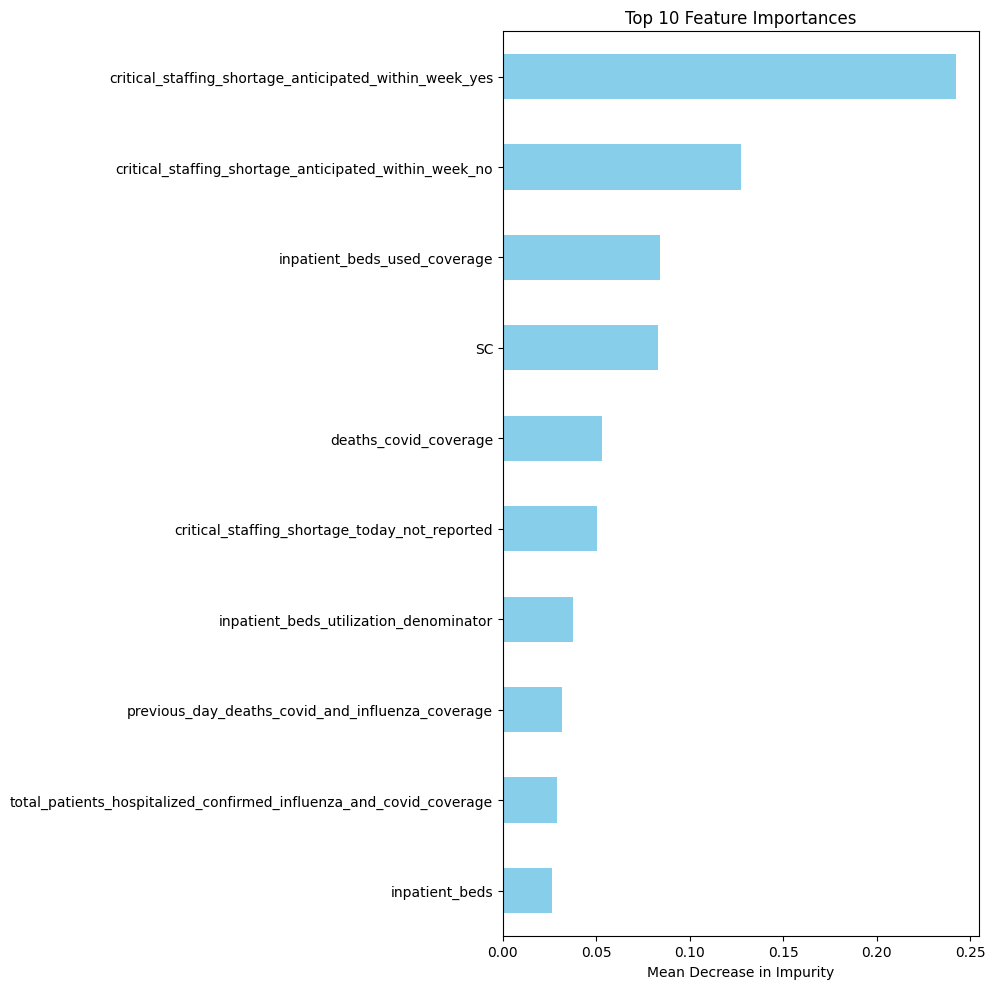

In [141]:
# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

# Select top 10 features
top_10_features = feature_importances.sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 10))
top_10_features.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Feature Importances')
plt.xlabel('Mean Decrease in Impurity')
plt.tight_layout()
plt.show()

In [142]:
top_10_features

,0
critical_staffing_shortage_anticipated_within_week_yes,0.242549
critical_staffing_shortage_anticipated_within_week_no,0.127396
inpatient_beds_used_coverage,0.084230
SC,0.082904
deaths_covid_coverage,0.053122
critical_staffing_shortage_today_not_reported,0.050391
inpatient_beds_utilization_denominator,0.037407
previous_day_deaths_covid_and_influenza_coverage,0.031832
total_patients_hospitalized_confirmed_influenza_and_covid_coverage,0.029029
inpatient_beds,0.026081


Our next question was which features in the collected data are most influential in predicting hospital strain, which we examined using Random Forests. Based on the mean decrease in impurity, the most significant features for predicting hospital strain are whether a hospital anticipates a critical staffing shortage within the next week. This aligns with real-world expectations, as hospitals often have a good understanding of their staffing capacity and can predict when they will be under strain.

This finding emphasizes the importance of listening to hospitals directly when making decisions about resource and staff allocation. Interestingly, a hospital's "subjective" assessment of potential strain was found to be more important than other more objective measures in the dataset. This suggests that, even with data-driven tools, hospitals' own insights about their resources are critical for accurate predictions of strain.

The next most critical features were inpatient_beds_used_coverage, SC, deaths_covid_coverage. These mean: the number of hospitals reporting "inpatient_beds_used" in a state-day observation, the state South Carolina, and the number of hospital facilities that reported COVID-19 deaths. This is interesting because these features do not appear directly to be linked to hospital strain, yet they are in the top 5 most important features.